In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import Image
import numpy as np
import tqdm
from matplotlib import pyplot as plt
%matplotlib inline


from pathlib import Path

torch.cuda.set_device(1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
net = torchvision.models.resnet18(pretrained=False)
net = net.to(device)

In [4]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
# adjust last layer to this task 
num_fc_input = net.fc.in_features
print(num_fc_input)
net.fc = nn.Linear(num_fc_input, 2).cuda()

weight_path = '../models/train_best.pt'
net.load_state_dict(torch.load(weight_path))


512


<All keys matched successfully>

In [6]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# 前処理
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [5]:
image_dir = Path('./data/frames')
csv_path = Path('./data/train_re.txt')

assert image_dir.exists()
assert csv_path.exists()

In [6]:
# DataSetクラス
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self):
        super(CustomDataset, self).__init__()

        # 前処理クラスを受け取る
        self.transform = transform

        # ラベルの用意
        img_list = []
        label_list = []

        pos_num = 0
        neg_num = 0

        for record in csv_path.open("r").readlines():
            img_idx, label = record.strip().split(',')
            image_path = image_dir / ('frame_' + img_idx + '.jpg')
            assert image_path.exists()
            img_list.append(str(image_path))
            label_list.append(int(label))

            if int(label) == 0:
                neg_num += 1
            else:
                pos_num += 1
        
        self.images = img_list
        self.labels = label_list
        total = neg_num + pos_num
        self.num_balance = [float(neg_num)/total, float(pos_num)/total]

        print(self.num_balance)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        with open(image, 'rb') as f:
            image = Image.open(f)
            image = image.convert('RGB')
        
        # 前処理を入れる
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

c = CustomDataset()
c.labels[0:3], c.images[0:3]


[0.8240740740740741, 0.17592592592592593]


([0, 0, 0],
 ['data/frames/frame_00000.jpg',
  'data/frames/frame_00001.jpg',
  'data/frames/frame_00002.jpg'])

In [7]:
custom_dataset = CustomDataset()


# split dataset into train and val 
n_samples = len(c) # n_samples is 60000
print("n_samples", n_samples)
train_size = int(len(custom_dataset) * 0.8) # train_size is 48000
val_size = n_samples - train_size # val_size is 48000
print("train_size", train_size, "val_size", val_size)

# shuffleしてから分割してくれる.
train_dataset, val_dataset = torch.utils.data.random_split(custom_dataset, [train_size, val_size])


custom_train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=32,
                                            shuffle=True
                                            )
custom_val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                            batch_size=32,
                                            shuffle=True
                                            )

for r in custom_train_loader:
    print(len(r[0]))
    break


[0.8240740740740741, 0.17592592592592593]
n_samples 5400
train_size 4320 val_size 1080
32


In [8]:
# loss function


# calc occurence ratio
# weight on flagman flame

weights = torch.tensor([custom_dataset.num_balance[1], custom_dataset.num_balance[0]]).cuda()
#criterion = nn.BCELoss(weight=weights)
criterion = nn.CrossEntropyLoss(weight=weights)
#input = torch.randn(3, requires_grad=True)
#target = torch.empty(3).random_(2)
#output = loss(m(input), target)
#output.backward()


[0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0] <class 'numpy.ndarray'>
torch.Size([32, 3, 480, 640])
<class 'torch.Tensor'> torch.Size([3, 1925, 5129])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


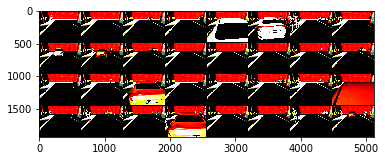

In [9]:
# visualize samples
def show(img):
    print(type(img), img.shape)
    npimg = img.numpy()  # torch(Tensor) format → numpy format
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


for i, (images, labels) in enumerate(custom_train_loader):
    print(labels.numpy(), type(labels.numpy()))

    print(images.shape)

    # make_grid(): 
    show(torchvision.utils.make_grid(images, padding=1))
    # plt.axis('off')
    break

In [10]:
# train model

optimizer = optim.Adam(
    net.parameters(),
)
num_epochs = 200

train_loss_list = []
train_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    total_tp = 0
    toral_pos = 0
    val_tp = 0
    val_toral_pos = 0

    net.train()
    with tqdm.tqdm(custom_train_loader, ncols=100) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(images)
            # print(outputs.max(1)[1], labels)
            # print(outputs, labels)
            # print('est, gt = ', outputs.shape, labels.shape)
            loss = criterion(outputs, labels)

            train_loss += loss.item()
            train_acc += (outputs.max(1)[1] == labels).sum().item()

            # positive(flagman) sample
            labels_a = labels.cpu().numpy()
            est_a = (outputs.max(1)[1]).cpu().numpy()
            cond_idx = np.where(labels_a == 1)  # positive label
            cnt_1 = est_a[cond_idx]
            tp = np.count_nonzero(cnt_1 == 1)
            # print(tp)
            pos_num = len(cnt_1)

            total_tp += tp
            toral_pos += pos_num

            loss.backward()
            optimizer.step()

    avg_train_loss = train_loss / len(custom_train_loader.dataset)
    avg_train_acc = train_acc / len(custom_train_loader.dataset)
    true_pos_rate = total_tp / toral_pos
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)

    # val 
    net.eval()
    with torch.no_grad():
        for images, labels in custom_val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()


            labels_a = labels.cpu().numpy()
            est_a = (outputs.max(1)[1]).cpu().numpy()
            cond_idx = np.where(labels_a == 1)
            cnt_1 = est_a[cond_idx]
            tp = np.count_nonzero(cnt_1 == 1)
            # print(tp)
            pos_num = len(cnt_1)

            val_tp += tp
            val_toral_pos += pos_num

    avg_val_loss = val_loss / len(custom_val_loader.dataset)
    avg_val_acc = val_acc / len(custom_val_loader.dataset)
    val_true_pos_rate = val_tp / val_toral_pos

    
    
    #print(epoch, "epoch",avg_train_loss)
    print ('Epoch [{}/{}], Loss: {loss:.4f}, train acc: {train_acc:.4f}, TP: {tp:.4f} '
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, train_acc=avg_train_acc, tp=true_pos_rate), end=" ")
    print('val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, val_TP: {tp:.4f}'.format(val_loss=avg_val_loss, val_acc=avg_val_acc, tp=val_true_pos_rate))

 51%|███████████████████████████████▋                              | 69/135 [00:39<00:37,  1.74it/s]


KeyboardInterrupt: 

In [11]:
# weight_path = '/content/drive/My Drive/Colab Notebooks/datasets/tmctf_wildcard_300/test_resnet18_wild.pt'
weight_path = "../models/sample.pt"
torch.save(net.state_dict(), weight_path)

## reference
- [PyTorchで学習済みモデルを元に自前画像をtrainしてtestするまで - Stimulator](https://vaaaaaanquish.hatenablog.com/entry/2018/09/15/213253)
- [[PyTorch]不均衡データのを扱うための損失関数 - Qiita](https://qiita.com/Kosuke-Szk/items/0e28e726d76bcd7e1612)